# emodpy-tbhiv simple example
This notebook provides a example of using emodpy-tbhiv to commission an EMOD (DTK) simulation of TB transmission on COMPS. It uses publicly available demographics data from Malawi. First, we will import all required packages.

If you are unfamiliar with Jupyter notebooks, [Codecademy](https://www.codecademy.com/articles/getting-started-with-jupyter) has a Getting started tutorial that walks through the basics of using Jupyter to run code on the web. The [Jupyter docs](https://jupyter.org/documentation) are also a great resource for more detailed information.

This notebook is designed to be executed sequentially. Once you get to the end, depending on how much of the functionality you've been able to internalize, you'll see how you can go back and make code changes and execute code blocks selectively.

<h1> EMOD TBHIV Quickstart </h1>

<b>NOTE:</b> In order to avoid execution collitions between users, please run step below. Also, making a copy of this notebook under the same directory is suggested.

In [1]:
import workspace

# Libraries and scripts needed
Below, you will find the list of all the libraries and scripts that will be needed along this sample.

In [4]:
import pathlib # for a join
import shutil
import os
from functools import partial  # for setting Run_Number.

# idmtools ...
from idmtools.assets import Asset, AssetCollection  #
from idmtools.builders import SimulationBuilder
from idmtools.core.platform_factory import Platform
from idmtools.entities.experiment import Experiment
from idmtools_models.templated_script_task import get_script_wrapper_unix_task

# emodpy
from emodpy.emod_task import EMODTask
import emodpy.emod_task as emod_task
from emodpy_tbhiv.reporters.plugin import Report_TBHIV_ByAge

# local files for this experiment.
import params
import set_config
import manifest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

INI File Used: /home/idmuser/tbhiv/SA/idmtools.ini


# The process:

EMOD tasks require a set of functions that are passed as parameters. In the next sections, we will be creating those functions, running the task and plotting the results and sweeping some parameters:

1. Function: Config Builder
2. Function: Campaing Builder
3. Function: Demographics Builder

Next:

- Reporter Setup, 
- Platform Setup and Kernel import
- Task creation
- Simulation creation
- Experiment
- Plot

## 1. Function: Config Builder
Set everything up... Let's start with config params. Notice that we are putting these each in functions. These functions get passed to the EMODTask creator later on.

In [7]:
def set_param_fn(config): 
    """
    This function is a callback that is passed to emod-api.config to set parameters The Right Way.
    """
    config = set_config.set_config( config )
    config.parameters.x_Other_Mortality =  0.34
    config.parameters.x_Birth =  1.43
    config.parameters.TB_MDR_Fitness_Multiplier =  1.0 #no fitness cost worst case
    config.parameters.Simulation_Duration =  3650
    config.parameters.TB_Smear_Negative_Infectivity_Multiplier = 0.34604
    config.parameters.TB_Presymptomatic_Rate = 0.01165
    config.parameters.TB_Active_Presymptomatic_Infectivity_Multiplier = 0.34604*0.3318
    config.parameters.TB_Slow_Progressor_Rate =  0.007/365.0
    config.parameters.pop( "Serialized_Population_Filenames" )
    config.parameters.Report_Event_Recorder_Events = ["TBActivationPresymptomatic","Hello","Oh_No_I_Have_HIV","Yay","ArtDistributed"]
    config.parameters["logLevel_Individual"] = "INFO"

    return config

## 2. Function: Campaign Builder
Now we add a campaign builder function.

In [14]:
def build_camp():
    """
    Import all campaign builder API functions, from emod_api and emodpy_tbhiv...
    """
    import emod_api.campaign as camp
    import emod_api.interventions.utils as utils
    import emodpy_tbhiv as tbhiv
    import emod_api.interventions.outbreak as ob
    import emodpy_tbhiv.interventions.art as art
    import emodpy_tbhiv.interventions.bcg as bcg
    import emodpy_tbhiv.interventions.active_diagnostic as ad
    import emodpy_tbhiv.interventions.hiv_diag as hd
    from emodpy_tbhiv.interventions import purge_campaign_event

    # Seed the outbreak
    camp.set_schema( manifest.schema_file ) # use this once we update our emod-api
    # camp.schema_path = manifest.schema_file # old way
    seed = ob.seed_by_coverage( camp, 40, 0.5 )
    camp.add( seed )
    purge_campaign_event( seed )

    # Create our campaign with interventions. Some are scheduled...
    camp.add( art.ART( camp, ["TBActivationPresymptomatic"], start_day=10 ) )
    camp.add( bcg.BCG( camp, ["TBActivationPresymptomatic"], start_day=10 ) )
    
    # And others are triggered
    camp.add( ad.ActiveDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=1, pos_event="Hello" ) )
    camp.add( hd.HIVDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=1, pos_event="Oh_No_I_Have_HIV", neg_event="Yay" ) )
    
    return camp

## 3. Function: Demographics Builder
With the configuration and campaign taken care of, let's move on to the demographics file. We're going to write a function for that too, and create a simple single node demographics file with 10,000 people, and the mortality will be based on data, and even infers the natural mortality from total mortality (including HIV mortality), using the data files we downloaded earlier.

In [8]:
def build_demog():
    """
    Build a demographics input file for the DTK. This is going to be a single node, with 10,000 individuals
    and with the fertility, age structure, and mortality set up using TBHIV defaults (not covered here). 
    The male and female input files are historical all-cause mortality so that we can use some math to back
    out natural mortality from HIV mortality.
    """
    import emodpy_tbhiv.demographics.TBHIVDemographics as Demographics # OK to call into emod-api

    demog = Demographics.fromData( pop=10000, filename_male=manifest.males, filename_female=manifest.females )
    
    return demog

## Reporter
Finally let's set up our reporter. This doesn't go in a function.

In [9]:
from emodpy_tbhiv.reporters.plugin import Report_TBHIV_ByAge
report = Report_TBHIV_ByAge()
report.configure_report(200, 0, 0, 200, ["HappyBirthday","Hello","Oh_No_I_Have_HIV", "Yay", "ArtDistributed", "BcgDistributed"])    
report.asset_dir = manifest.plugins_folder

## Platform
With our data input files taken care of, it's time to create the Platform, Task, Simulation, and Experiment. First the platform...

In [10]:
# Create a 'platform'. This is our compute target. We are going to run these simulations on the IDM Calculon cluster
# via the COMPS scheduler. This step will prompt for COMPS credentials in the browser.
# Show how to dynamically set priority and node_group
platform = Platform("SLURM", node_group="idm_48cores", priority="Highest")


[SLURM]
{
   "type": "COMPS",
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon",
   "priority": "Highest",
   "simulation_root": "$COMPS_PATH(USER)\\output",
   "num_retries": "0",
   "node_group": "idm_48cores",
   "num_cores": "1",
   "exclusive": "False"
}


## Kernel (exe file)
Before we create the task, we want to pull down the model binary and supporting files.

In [11]:
import emod_tbhiv.bootstrap as dtk
where_to_put_it = pathlib.Path(manifest.eradication_path).parent
dtk.setup( where_to_put_it )

# Task Creation
The EMODTask method signature is composed of the next arguments: 

    - eradication_path:  manifest.eradication_path (location of the eradication.exe file)
    - campaign_builder:  build_camp function defined above.
    - schema_path:       manifest.schema_file
    - param_custom_cb:   set_param_fn
    - ep4_custom_cb:     ep4_fn
    - demog_builder:     build_demog function defined above.
    - plugin_report:     report
    - config_path:       output path for generated config.json

In [12]:
# ep4 stands for Embedded Python Pre- And Post-Processing. These are generally optional scripts for doing data
# manipulation just before or just after the DTK runs, using Python, because often thet is much easier.
def ep4_fn(task):
    task = emod_task.add_ep4_from_path(task, manifest.ep4_dir)
    return task

In [15]:
task = EMODTask.from_default2(
        eradication_path=manifest.eradication_path,
        campaign_builder=build_camp,
        schema_path=manifest.schema_file,
        param_custom_cb=set_param_fn,
        ep4_custom_cb=ep4_fn,
        demog_builder=build_demog,
        plugin_report=report,
        config_path="my_config.json"
    )

# Use a Singularity Image File to run 'inside of' on COMPS
# Singularity is a container-technology like docker that lets us run inside a completely personalied run-time environment.
task.set_sif( manifest.sif )

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f1fed7aa598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Generating demographics file demographics.json.
Campaign is publishing the following events:
Hello
ArtDistributed
Oh_No_I_Have_HIV
BcgDistributed
Yay
Campaign is listening to the following events:
TBActivationPresymptomatic
Campaign is IGNORING the following events:
ArtDistributed
Oh_No_I_Have_HIV
Hello
BcgDistributed
Yay
Campaign is LISTENING to the following non-campaign events:
TBActivationPresymptomatic
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.


## Simulation setup
Next, set up the Simulation, which includes the sweep over Run Number...

In [16]:
def update_sim_random_seed(simulation, value):
    simulation.task.config.parameters.Run_Number = value
    return {"Run_Number": value}

## Simulation sweep with builder

In [17]:
# Create simulation sweep with builder
builder = SimulationBuilder()
builder.add_sweep_definition( update_sim_random_seed, range(params.nSims) )

### Run the Experiment

In [18]:
def run_test():
    
    # create experiment from builder
    experiment  = Experiment.from_builder(builder, task, name=params.exp_name) 

    # The last step is to call run() on the ExperimentManager to run the simulations.
    experiment.run(wait_until_done=True, platform=platform)

    # Check result
    if not experiment.succeeded:
        print(f"Experiment {experiment.uid} failed.\n")
        exit()

    print(f"Experiment {experiment.uid} succeeded.")

    # Save experiment id to file
    with open("COMPS_ID", "w") as fd:
        fd.write(experiment.uid.hex)
    print(experiment.uid.hex)
    return experiment.uid

# Run the experiment and saves the experiment id for later use.
experiment_id = run_test()

Removing unneeded asset: <Asset: reporter_plugins/libreporteventcounter.so from /home/idmuser/tbhiv/SA/download/reporter_plugins/libreporteventcounter.so>.

The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=e1b0b84f-584d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Creating Simulations on Comps:   0%|          | 0/2 [00:00<?, ?simulation/s]        

Creating Simulations on Comps: 100%|██████████| 2/2 [00:00<00:00,  4.00simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 2/2 [00:26<00:00, 13.12s/simulation]

Experiment e1b0b84f-584d-ec11-a9f1-9440c9be2c51 succeeded.
e1b0b84f584dec11a9f19440c9be2c51



### Experiment results download and plot
Let's show some output.


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment e1b0b84f-584d-ec11-a9f1-9440c9be2c51 into e1b0b84f-584d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=eda09de6-584d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment e1b0b84f-584d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:15<00:00, 15.20s/workitem]

Removing e1b0b84f-584d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem eda09de6-584d-ec11-a9f1-9440c9be2c51


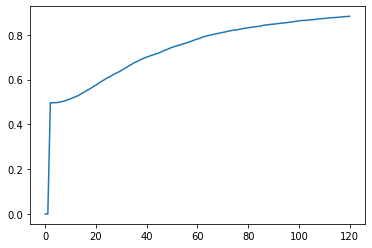

In [19]:
from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)     # With the experiment id from previous section, we download the output files.
dl(manifest.output_dl_folder)
subdir = os.listdir(manifest.output_dl_folder)[-1] # get the most recent

import json
tb_prev = json.load( open( manifest.output_dl_folder + "/" + subdir + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]

import matplotlib.pyplot as plt
plt.plot( tb_prev )


## Simulation sweep with builder 
We could sweep over a model value not just random number seed. Below we sweep over 10 values of Base_Infectivity_Constant.

In [20]:
def update_sim_bic(simulation, value):
    simulation.task.config.parameters.Base_Infectivity_Constant = value*0.1
    return {"Base_Infectivity": value*0.1}

# Create simulation sweep with builder
builder = SimulationBuilder()
builder.add_sweep_definition( update_sim_bic, range(10) )

experiment_id = run_test()


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=1746ae0e-5a4d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Creating Simulations on Comps:   0%|          | 0/10 [00:00<?, ?simulation/s]          

Creating Simulations on Comps: 100%|██████████| 10/10 [00:00<00:00, 21.41simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 10/10 [00:36<00:00,  3.65s/simulation]

Experiment 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51 succeeded.
1746ae0e5a4dec11a9f19440c9be2c51


### Download the results

In [21]:
from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51 into 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=c2dbb225-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:05<00:00,  5.07s/workitem]

Removing 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem c2dbb225-5a4d-ec11-a9f1-9440c9be2c51


### Plot your data


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51 into 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=8adcb225-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:10<00:00, 10.13s/workitem]

Removing 1746ae0e-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem 8adcb225-5a4d-ec11-a9f1-9440c9be2c51


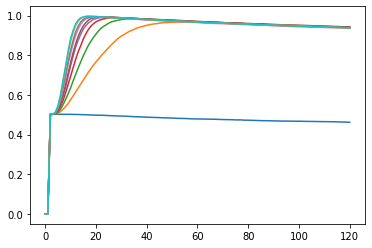

In [22]:
import json
import matplotlib.pyplot as plt

manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)
sims = os.listdir(manifest.output_dl_folder)
prevs = []
for sim in sims:
    tb_prev = json.load( open( manifest.output_dl_folder + "/" + sim + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
    prevs.append( tb_prev )
    plt.plot( tb_prev )

Now let's sweep over percentage of fast progressors...


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=0549c02b-5a4d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Creating Simulations on Comps:   0%|          | 0/10 [00:00<?, ?simulation/s]          

Creating Simulations on Comps: 100%|██████████| 10/10 [00:00<00:00, 18.53simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 10/10 [00:21<00:00,  2.12s/simulation]

Experiment 0549c02b-5a4d-ec11-a9f1-9440c9be2c51 succeeded.
0549c02b5a4dec11a9f19440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 0549c02b-5a4d-ec11-a9f1-9440c9be2c51 into 0549c02b-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=4b18273b-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 0549c02b-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:10<00:00, 10.12s/workitem]

Removing 0549c02b-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem 4b18273b-5a4d-ec11-a9f1-9440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 0549c02b-5a4d-ec11-a9f1-9440c9be2c51 into 0549c02b-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=b2732141-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 0549c02b-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:10<00:00, 10.24s/workitem]

Removing 0549c02b-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem b2732141-5a4d-ec11-a9f1-9440c9be2c51


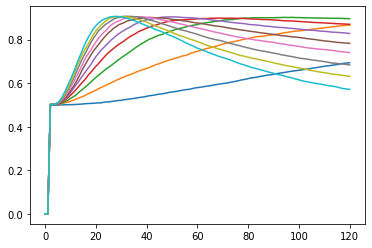

In [23]:
def update_sim_fp(simulation, value):
    simulation.task.config.parameters.TB_Fast_Progressor_Fraction_Adult = value*0.1
    return {"TB_Fast_Progressor_Fraction_Adult": value*0.1}

# Create simulation sweep with builder
builder = SimulationBuilder()
builder.add_sweep_definition( update_sim_fp, range(10) )

experiment_id = run_test()

from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)

import json
import matplotlib.pyplot as plt

manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)
sims = os.listdir(manifest.output_dl_folder)
prevs = []
for sim in sims:
    tb_prev = json.load( open( manifest.output_dl_folder + "/" + sim + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
    prevs.append( tb_prev )
    plt.plot( tb_prev )

And slow progressor rate. Except here we reduce the fraction of fast progressors to 10%, so 90% are slow, and we extend the simulation duration out to 30 years. Note that the x axis is a bit confusing in all these because we are using 1 month timesteps and the x-axis labels are "timesteps" not days.


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=4c7c1947-5a4d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Creating Simulations on Comps:   0%|          | 0/10 [00:00<?, ?simulation/s]         

Creating Simulations on Comps: 100%|██████████| 10/10 [00:00<00:00, 10.06simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 10/10 [00:20<00:00,  2.09s/simulation]

Experiment 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51 succeeded.
4c7c19475a4dec11a9f19440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51 into 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=e86d0953-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:05<00:00,  5.09s/workitem]

Removing 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem e86d0953-5a4d-ec11-a9f1-9440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51 into 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=c7a53a59-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:05<00:00,  5.14s/workitem]

Removing 4c7c1947-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem c7a53a59-5a4d-ec11-a9f1-9440c9be2c51


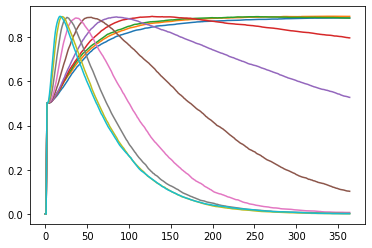

In [24]:
def update_sim_fp(simulation, value):
    rate = 10**(0.5*value) *1e-06
    simulation.task.config.parameters.TB_Slow_Progressor_Rate = rate
    return {"TB_Slow_Progressor_Rate": rate}

# Create simulation sweep with builder
task.config.parameters.TB_Fast_Progressor_Fraction_Adult = 0.1
task.config.parameters.TB_Fast_Progressor_Fraction_Child = 0.1
task.config.parameters.Simulation_Duration = 3650*3

builder = SimulationBuilder()
builder.add_sweep_definition( update_sim_fp, range(10) )

experiment_id = run_test()

from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)

import json
import matplotlib.pyplot as plt

manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)
sims = os.listdir(manifest.output_dl_folder)
prevs = []
for sim in sims:
    tb_prev = json.load( open( manifest.output_dl_folder + "/" + sim + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
    prevs.append( tb_prev )
    plt.plot( tb_prev )


Now let's move onto the campaign side of things and demonstrate how one might sweep over a campaign param, perhaps to demonstrate parametery sensitivity.


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=2b51f15f-5a4d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Use of first flag is deprecated. Use set_schema to start build a new, empty campaign.
Campaign is publishing the following events:
Hello
ArtDistributed
Oh_No_I_Have_HIV
BcgDistributed
Yay
Campaign is listening to the following events:
TBActivationPresymptomatic
Campaign is IGNORING the following events:
ArtDistributed
Oh_No_I_Have_HIV
Hello
BcgDistributed
Yay
Campaign is LISTENING to the following non-campaign events:
TBActivationPresymptomatic
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.
Use of first flag is deprecated. Use set_schema to start build a new, empty campaign.
Campaign is publishing the following events:
Hello
ArtDistributed
Oh_No_I_Have_HIV
BcgDistributed
Yay
Campaign is listening to the following events:
TBActivationPresymptomatic
Campaign is IGNORING the following events:
ArtDistributed
Oh_No_I_Have_HIV
Hello
BcgDistributed
Yay
Campaign is LISTENING to the following non-campaign ev

Creating Simulations on Comps:   0%|          | 0/10 [00:00<?, ?simulation/s]             

Found adhoc events in campaign. Needs some special processing behind the scenes.


Creating Simulations on Comps: 100%|██████████| 10/10 [00:00<00:00, 19.02simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 10/10 [00:31<00:00,  3.15s/simulation]

Experiment 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51 succeeded.
2b51f15f5a4dec11a9f19440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51 into 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=cc70b272-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:10<00:00, 10.14s/workitem]

Removing 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem cc70b272-5a4d-ec11-a9f1-9440c9be2c51



[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51 into 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=d58bdb79-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:10<00:00, 10.18s/workitem]

Removing 2b51f15f-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem d58bdb79-5a4d-ec11-a9f1-9440c9be2c51


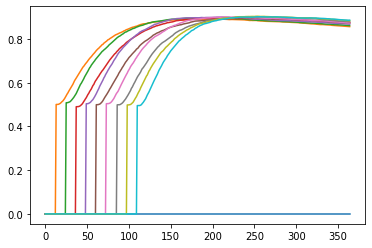

In [25]:
def build_camp( outbreak_start_day = 40 ):
    """
    Import all campaign builder API functions, from emod_api and emodpy_tbhiv...
    """
    import emod_api.campaign as camp
    import emod_api.interventions.outbreak as ob
    import emod_api.interventions.utils as utils
    import emodpy_tbhiv as tbhiv
    import emodpy_tbhiv.interventions.art as art
    import emodpy_tbhiv.interventions.bcg as bcg
    import emodpy_tbhiv.interventions.active_diagnostic as ad
    import emodpy_tbhiv.interventions.hiv_diag as hd
    from emodpy_tbhiv.interventions import purge_campaign_event

    # Seed the outbreak
    camp.schema_path = manifest.schema_file
    seed = ob.seed_by_coverage( camp, outbreak_start_day, 0.5 )
    purge_campaign_event( seed )
    camp.add( seed, first=True )

    # Create our campaign with interventions. Some are scheduled...
    camp.add( art.ART( camp, ["TBActivationPresymptomatic"], start_day=10 ) )
    camp.add( bcg.BCG( camp, ["TBActivationPresymptomatic"], start_day=10 ) )
    
    # And others are triggered
    camp.add( ad.ActiveDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=1, pos_event="Hello" ) )
    camp.add( hd.HIVDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=1, pos_event="Oh_No_I_Have_HIV", neg_event="Yay" ) )
    
    return camp

def update_campaign_start_day(simulation, value):
    value = value * 365
    build_campaign_partial = partial(build_camp, outbreak_start_day=value)
    simulation.task.create_campaign_from_callback(build_campaign_partial)
    return {"outreak_start_day": value}

builder = SimulationBuilder()
builder.add_sweep_definition( update_campaign_start_day, range(10) )

experiment_id = run_test()

from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)

import json
import matplotlib.pyplot as plt

manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder)
sims = os.listdir(manifest.output_dl_folder)
prevs = []
for sim in sims:
    tb_prev = json.load( open( manifest.output_dl_folder + "/" + sim + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
    prevs.append( tb_prev )
    plt.plot( tb_prev )

Finally, we're going to do a campaign sweep where we sweep over the start day of our ART distribution (and related interventions). The visualization is a bit ugly, it's showing the number of ArtDistributed events over time from the ReportEventRecorder.csv file.


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=57f05080-5a4d-ec11-a9f1-9440c9be2c51
Simulations are still being created



Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Use of first flag is deprecated. Use set_schema to start build a new, empty campaign.
Campaign is publishing the following events:
Hello
ArtDistributed
Oh_No_I_Have_HIV
BcgDistributed
Yay
Campaign is listening to the following events:
TBActivationPresymptomatic
Campaign is IGNORING the following events:
ArtDistributed
Oh_No_I_Have_HIV
Hello
BcgDistributed
Yay
Campaign is LISTENING to the following non-campaign events:
TBActivationPresymptomatic
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.
Use of first flag is deprecated. Use set_schema to start build a new, empty campaign.
Campaign is publishing the following events:
Hello
ArtDistributed
Oh_No_I_Have_HIV
BcgDistributed
Yay
Campaign is listening to the following events:
TBActivationPresymptomatic
Campaign is IGNORING the following events:
ArtDistributed
Oh_No_I_Have_HIV
Hello
BcgDistributed
Yay
Campaign is LISTENING to the following non-campaign ev

Creating Simulations on Comps:   0%|          | 0/10 [00:00<?, ?simulation/s]             

Found adhoc events in campaign. Needs some special processing behind the scenes.


Creating Simulations on Comps: 100%|██████████| 10/10 [00:00<00:00, 10.49simulation/s]
Waiting on Experiment TBHIV South Africa Sample Experiment to Finish running: 100%|██████████| 10/10 [00:37<00:00,  3.71s/simulation]

Experiment 57f05080-5a4d-ec11-a9f1-9440c9be2c51 succeeded.
57f050805a4dec11a9f19440c9be2c51

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/ReportEventRecorder.csv'] for experiment 57f05080-5a4d-ec11-a9f1-9440c9be2c51 into 57f05080-5a4d-ec11-a9f1-9440c9be2c51.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=87e2a597-5a4d-ec11-a9f1-9440c9be2c51



Waiting on WorkItem Filter outputs for Experiment 57f05080-5a4d-ec11-a9f1-9440c9be2c51: 100%|██████████| 1/1 [00:05<00:00,  5.09s/workitem]

Removing 57f05080-5a4d-ec11-a9f1-9440c9be2c51/output.zip
Deleting workitem 87e2a597-5a4d-ec11-a9f1-9440c9be2c51


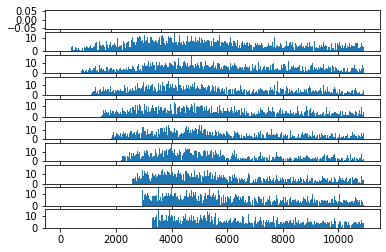

In [26]:
def build_camp( outbreak_start_day = 40, art_start = 10 ):
    """
    Import all campaign builder API functions, from emod_api and emodpy_tbhiv...
    """
    import emod_api.campaign as camp
    import emod_api.interventions.outbreak as ob
    import emod_api.interventions.utils as utils
    import emodpy_tbhiv as tbhiv
    import emodpy_tbhiv.interventions.art as art
    import emodpy_tbhiv.interventions.bcg as bcg
    import emodpy_tbhiv.interventions.active_diagnostic as ad
    import emodpy_tbhiv.interventions.hiv_diag as hd
    from emodpy_tbhiv.interventions import purge_campaign_event

    # Seed the outbreak
    camp.schema_path = manifest.schema_file
    seed = ob.seed_by_coverage( camp, outbreak_start_day, 0.05 )
    purge_campaign_event( seed )
    camp.add( seed, first=True )

    # Create our campaign with interventions. Some are scheduled...
    camp.add( art.ART( camp, ["TBActivationPresymptomatic"], start_day=art_start ) )
    camp.add( bcg.BCG( camp, ["TBActivationPresymptomatic"], start_day=art_start ) )
    
    # And others are triggered
    camp.add( ad.ActiveDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=art_start, pos_event="Hello" ) )
    camp.add( hd.HIVDiagnostic( camp, ["TBActivationPresymptomatic"], start_day=art_start, pos_event="Oh_No_I_Have_HIV", neg_event="Yay" ) )
    
    return camp

def update_campaign_start_day(simulation, value):
    value = value * 365
    build_campaign_partial = partial(build_camp, outbreak_start_day=40, art_start=value)
    simulation.task.create_campaign_from_callback(build_campaign_partial)
    return {"campaign_start_day": value}

builder = SimulationBuilder()
builder.add_sweep_definition( update_campaign_start_day, range(10) )

experiment_id = run_test()

from downloader import download as dl
manifest.output_dl_folder = str(experiment_id)
dl(manifest.output_dl_folder, files_to_get="output/ReportEventRecorder.csv")

import json
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
fig, axs = plt.subplots(10)
idx = 0

for sim in os.listdir(manifest.output_dl_folder):
    arts = defaultdict(int)
    arts[0] = 0
    with open( manifest.output_dl_folder + "/" + sim + "/" + "output/ReportEventRecorder.csv", 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            if row[0] == 'Time':
                continue
            time = int(row[0])
            event = row[2]
            if event == "ArtDistributed":
                arts[time] += 1
    if len(arts)>0:
        lists = sorted(arts.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        #plt.bar(x, y, width=10)
        axs[idx].bar(x, y, width=30)
    idx += 1